# General Imports

In [1]:
from os import getcwd, listdir, mkdir
from tqdm import tqdm
import cv2
from random import shuffle
import matplotlib.pyplot as plt
import sys
import numpy as np

In [2]:
DATA_DIR = "/characters/"
DATA_LOCATION = getcwd() + DATA_DIR
character_names = listdir(DATA_LOCATION)

In [3]:
def create_data(images_list):
    data = []
    for image_location in tqdm(images_list):
        character_name = image_location.split('/')[-2]
        resized_image = cv2.resize(cv2.imread(
            image_location, flags=cv2.IMREAD_GRAYSCALE), (32, 32), interpolation=cv2.INTER_AREA)
        data.append([np.array(resized_image), character_name])
    shuffle(data)
    return data

# Tensorflow Imports

In [4]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

# GAN
Implementation of Generative Adversarial Network with a MLP generator and discriminator.

Code: https://github.com/eriklindernoren/Keras-GAN/blob/master/gan/gan.py

Paper: https://arxiv.org/abs/1406.2661

In [5]:
img_rows = 32
img_cols = 32
channels = 1
img_shape = (img_rows, img_cols, channels)
latent_dim = 100
epochs = 10001
batch_size = 64
sample_interval = 500
optimizer = Adam(0.0002, 0.5)

try:
    mkdir("./gan_output")
except:
    pass

In [6]:
def build_generator():
    model = Sequential()

    model.add(Dense(256, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))

    # model.summary()

    noise = Input(shape=(latent_dim,))
    img = model(noise)

    return Model(noise, img)

In [7]:
def build_discriminator():
    model = Sequential()

    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))

    # model.summary()

    img = Input(shape=img_shape)
    validity = model(img)

    return Model(img, validity)

In [8]:
def train(training_data, character_name, epochs, batch_size=128, sample_interval=50, save_location=None, verbose=False):
    # Load the dataset
    X_train = training_data

    # Rescale -1 to 1
    # X_train = X_train / 127.5 - 1.
    # X_train = np.expand_dims(X_train, axis=3)

    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in tqdm(range(epochs)):

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random batch of images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        noise = np.random.normal(0, 1, (batch_size, latent_dim))

        # Generate a batch of new images
        gen_imgs = generator.predict(noise)

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(imgs, valid)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------

        noise = np.random.normal(0, 1, (batch_size, latent_dim))

        # Train the generator (to have the discriminator label samples as valid)
        g_loss = combined.train_on_batch(noise, valid)

        # Plot the progress
        if verbose:
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (epoch, d_loss[0], 100*d_loss[1], g_loss))

        # If at save interval => save generated image samples
        if epoch % sample_interval == 0:
            sample_images(epoch, character_name=character_name,
                          location=save_location)

In [9]:
def sample_images(epoch, character_name, location='/undefined'):
    r, c = 10, 10
    noise = np.random.normal(0, 1, (r * c, latent_dim))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    # fig = plt.figure(figsize=(20, 15))
    cnt = 0

    try:
        mkdir('%s/individual' % location)
    except:
        pass

    for i in range(r):
        for j in range(c):

            plt.imsave('%s/individual/%d.png' %
                       (location, cnt), gen_imgs[cnt, :, :, 0], cmap='gray_r')
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray_r')
            axs[i, j].axis('off')
            cnt += 1
    fig.savefig("%s/%d.png" % (location, epoch))
    plt.close()

100%|██████████| 2000/2000 [00:00<00:00, 23417.93it/s]

For character_23_ba
Reshaping Data...
Shapes: x_train = (2000, 32, 32, 1), y_train = (2000, 1)


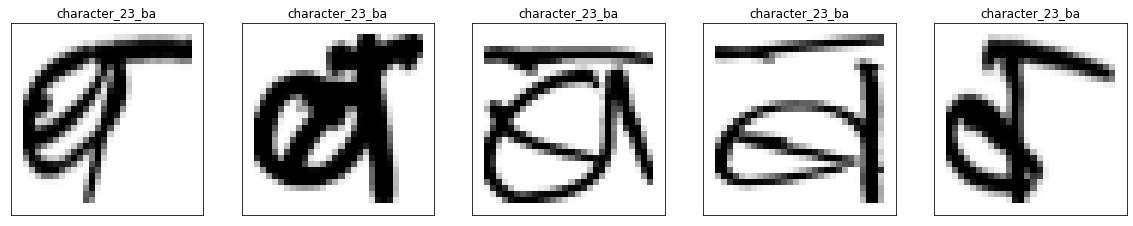

 34%|███▍      | 690/2000 [00:00<00:00, 6895.30it/s]

For character_12_thaa


100%|██████████| 2000/2000 [00:00<00:00, 6813.48it/s]


Reshaping Data...
Shapes: x_train = (2000, 32, 32, 1), y_train = (2000, 1)


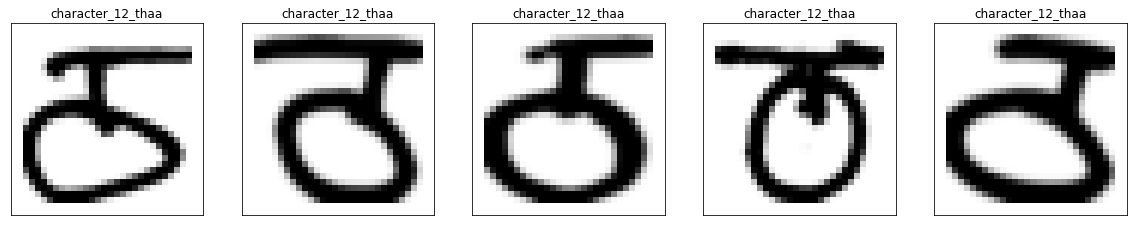

 33%|███▎      | 662/2000 [00:00<00:00, 6613.92it/s]

For character_01_ka


100%|██████████| 2000/2000 [00:00<00:00, 6469.34it/s]


Reshaping Data...
Shapes: x_train = (2000, 32, 32, 1), y_train = (2000, 1)


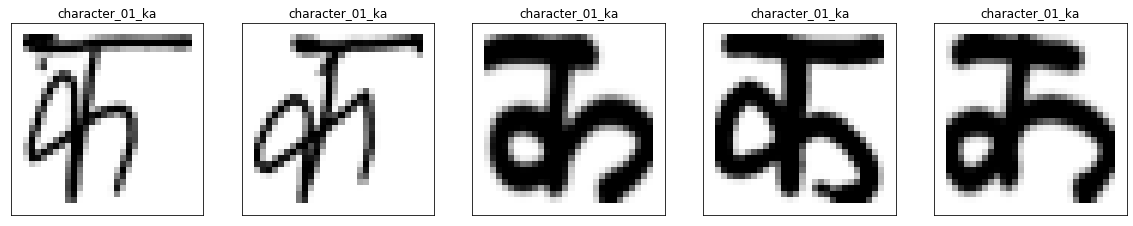

 33%|███▎      | 656/2000 [00:00<00:00, 6553.69it/s]

For character_15_adna


100%|██████████| 2000/2000 [00:00<00:00, 6709.77it/s]


Reshaping Data...
Shapes: x_train = (2000, 32, 32, 1), y_train = (2000, 1)


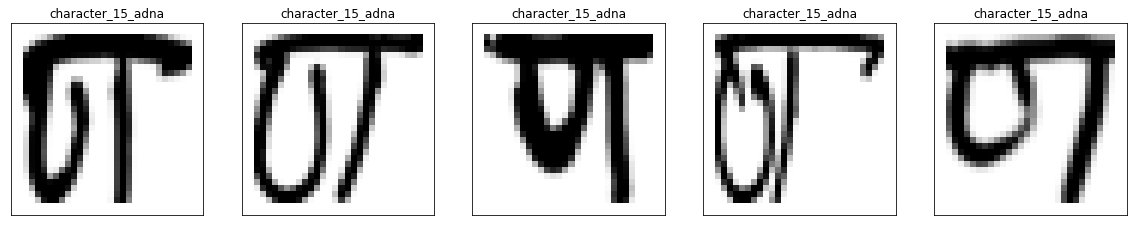

 34%|███▍      | 685/2000 [00:00<00:00, 6843.79it/s]

For character_21_pa


100%|██████████| 2000/2000 [00:00<00:00, 6702.24it/s]


Reshaping Data...
Shapes: x_train = (2000, 32, 32, 1), y_train = (2000, 1)


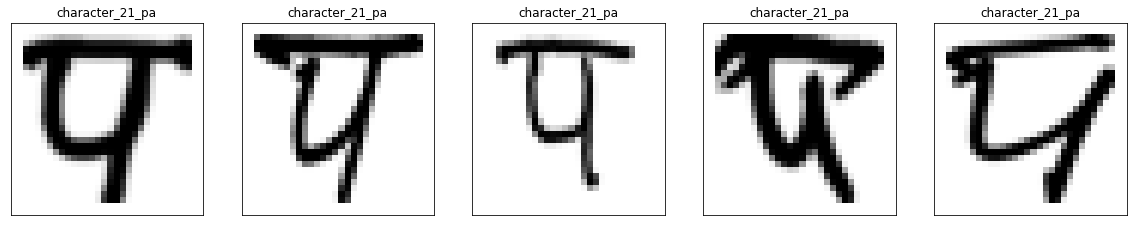

 34%|███▎      | 673/2000 [00:00<00:00, 6723.90it/s]

For character_13_daa


100%|██████████| 2000/2000 [00:00<00:00, 6870.02it/s]


Reshaping Data...
Shapes: x_train = (2000, 32, 32, 1), y_train = (2000, 1)


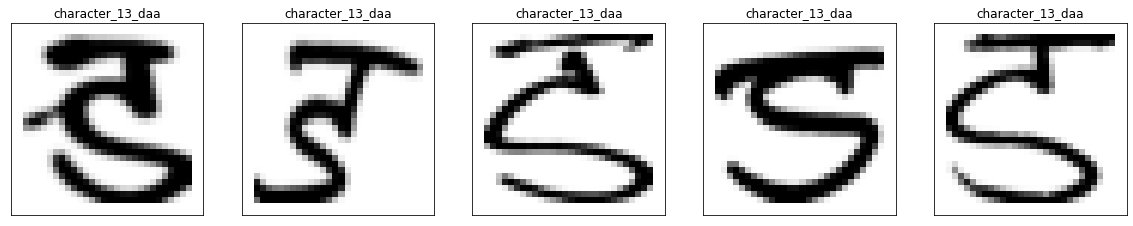

 34%|███▍      | 690/2000 [00:00<00:00, 6894.81it/s]

For character_06_cha


100%|██████████| 2000/2000 [00:00<00:00, 6585.67it/s]


Reshaping Data...
Shapes: x_train = (2000, 32, 32, 1), y_train = (2000, 1)


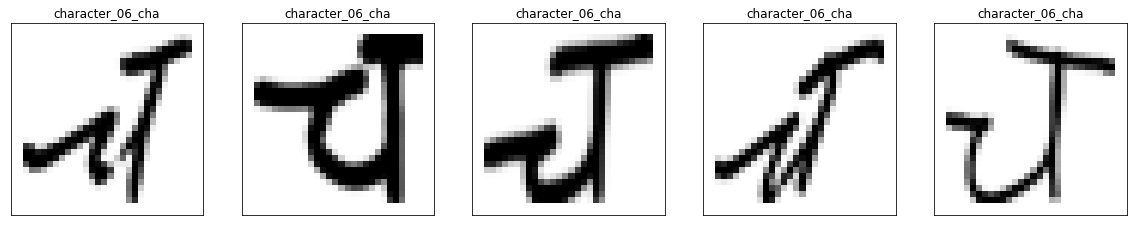

 34%|███▍      | 684/2000 [00:00<00:00, 6834.34it/s]

For character_11_taamatar


100%|██████████| 2000/2000 [00:00<00:00, 6845.57it/s]


Reshaping Data...
Shapes: x_train = (2000, 32, 32, 1), y_train = (2000, 1)


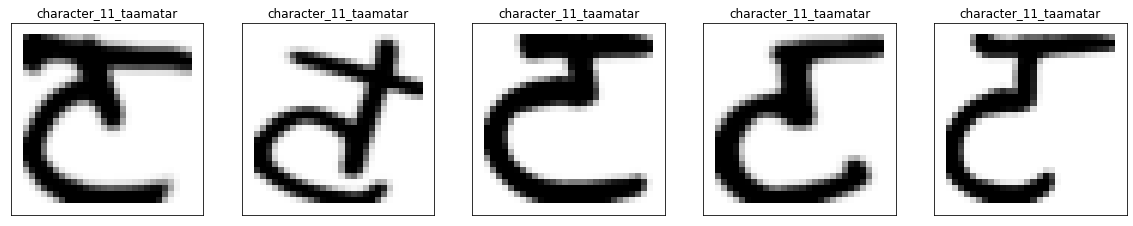

 35%|███▌      | 707/2000 [00:00<00:00, 7064.48it/s]

For character_16_tabala


100%|██████████| 2000/2000 [00:00<00:00, 6900.19it/s]


Reshaping Data...
Shapes: x_train = (2000, 32, 32, 1), y_train = (2000, 1)


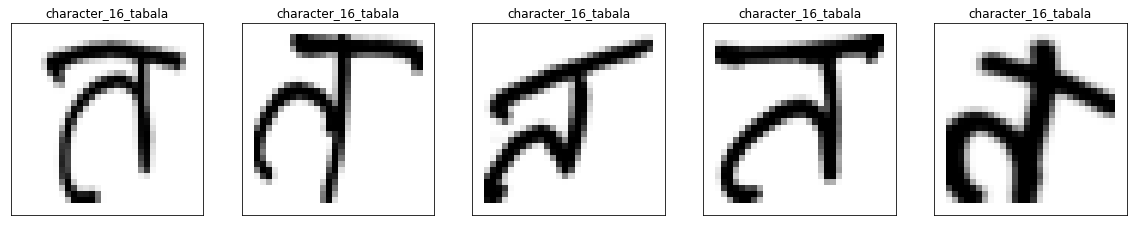

 35%|███▍      | 694/2000 [00:00<00:00, 6939.46it/s]

For character_27_ra


100%|██████████| 2000/2000 [00:00<00:00, 6704.76it/s]


Reshaping Data...
Shapes: x_train = (2000, 32, 32, 1), y_train = (2000, 1)


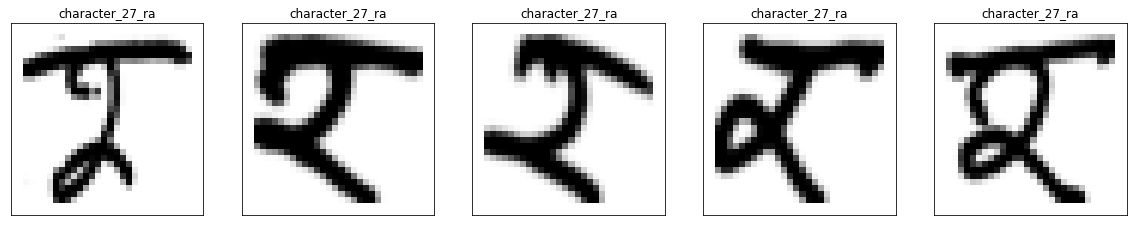

100%|██████████| 10001/10001 [11:18<00:00, 14.74it/s] 


In [10]:
for character_name in character_names:
    print("For %s" % character_name)
    character_location = DATA_LOCATION + character_name
    character_location_combined = []

    for image_file in listdir(character_location):
        character_location_combined.append(
            character_location + '/' + image_file)

    character_image_data = create_data(character_location_combined)

    print("Reshaping Data...")
    x_train = np.expand_dims(
        np.array([i[0] for i in character_image_data]), axis=-1)
    x_train = x_train.astype('float32')
    x_train = x_train / 255.0
    y_train = np.array([i[1] for i in character_image_data]).reshape(-1, 1)

    print("Shapes: x_train = %s, y_train = %s" %
          (x_train.shape, y_train.shape))

    fig = plt.figure(figsize=(20, 15))
    for i in range(5):
        ax = fig.add_subplot(1, 5, 1 + i, xticks=[], yticks=[])
        plt.imshow(character_image_data[i][0], cmap='gray_r')
        plt.title(character_image_data[i][1])
    plt.show()

    # Build and compile the discriminator
    discriminator = build_discriminator()
    discriminator.compile(loss='binary_crossentropy',
                               optimizer=optimizer,
                               metrics=['accuracy'])

    # Build the generator
    generator = build_generator()

    # The generator takes noise as input and generates imgs
    z = Input(shape=(latent_dim,))
    img = generator(z)

    # For the combined model we will only train the generator
    discriminator.trainable = False

    # The discriminator takes generated images as input and determines validity
    validity = discriminator(img)

    # The combined model  (stacked generator and discriminator)
    # Trains the generator to fool the discriminator
    combined = Model(z, validity)
    combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    # Train the model
    try:
        mkdir("gan_output/%s" % character_name)
    except:
        pass
    train(training_data=x_train, character_name=character_name, epochs=epochs,
          batch_size=batch_size, sample_interval=sample_interval, save_location="gan_output/%s" % character_name)